
#  Tunisian Real Estate Data Cleaning Pipeline

This notebook cleans and prepares Tunisian real estate data from multiple sources

## 0) Setup

In [2]:
%pip install numpy pandas matplotlib seaborn
from __future__ import annotations

import re
import unicodedata
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple, List
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

print("✓ Libraries imported successfully")



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp312-cp312-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -------------- ------------------------- 2.9/8.1 MB 10.5 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/8.1 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 11.2 MB/s eta 0:00:00
Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp312-cp312-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl (73 kB)
Note: you may need to restart the kernel to use updated packages.
✓ Libraries imported success

In [3]:
SCRAPED_DATA = r"C:\Users\Mediatek\Desktop\ML-project\ML\data\raw\final_scrapped_immobiliers.csv"
KAGGLE_DATA = r"C:\Users\Mediatek\Desktop\ML-project\ML\data\raw\tayara.csv"

# Data quality thresholds
IQR_MULTIPLIER = 5.0  # For outlier detection
MAX_BATHROOMS = 15
MAX_ROOMS = 20

print("✓ Configuration loaded")

✓ Configuration loaded


## 1) Utility functions


In [4]:
def strip_accents(text: str) -> str:
    """Remove accents from text while preserving meaning."""
    text = unicodedata.normalize("NFKD", str(text))
    return "".join(ch for ch in text if not unicodedata.combining(ch))


def normalize_text(text: str) -> str:
    """Comprehensive text normalization."""
    if pd.isna(text):
        return ""
    
    text = str(text)
    text = strip_accents(text).lower()
    text = text.replace("_", " ").replace("-", " ")
    text = re.sub(r"\bs\s*plus\s*", "s+", text)  # Normalize "s plus" -> "s+"
    text = re.sub(r"\s+", " ", text).strip()
    return text


def print_section(title: str, char: str = "="):
    """Print formatted section header."""
    print(f"\n{char * 80}")
    print(f"{title:^80}")
    print(f"{char * 80}\n")


def analyze_missing_values(df: pd.DataFrame, name: str = "Dataset"):
    """Comprehensive missing values analysis."""
    print_section(f"MISSING VALUES - {name}", "-")
    
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing': missing.values,
        'Percent': missing_pct.values
    })
    missing_df = missing_df[missing_df['Missing'] > 0].sort_values('Percent', ascending=False)
    
    if len(missing_df) > 0:
        print(missing_df.to_string(index=False))
        print(f"\n⚠️  Total columns with missing values: {len(missing_df)}")
        print(f"⚠️  Total missing values: {missing.sum():,}")
    else:
        print("✓ No missing values!")
    
    return missing_df

## 2) Data Loading

In [5]:
print_section("📂 LOADING DATA")
df_tayara = pd.read_csv(SCRAPED_DATA)
df_other  = pd.read_csv(KAGGLE_DATA)

print(f"Tayara dataset: {df_tayara.shape[0]:,} rows × {df_tayara.shape[1]} columns")
print(f"Other dataset:  {df_other.shape[0]:,} rows × {df_other.shape[1]} columns")
print(f"Total records:  {df_tayara.shape[0] + df_other.shape[0]:,}")


                                 📂 LOADING DATA                                 

Tayara dataset: 4,651 rows × 10 columns
Other dataset:  9,296 rows × 9 columns
Total records:  13,947


## 3) Data Exploration

In [6]:
print("\n=== TAYARA DATASET ===")
display(df_tayara.head(3))

print("\n=== OTHER DATASET ===")
display(df_other.head(3))


=== TAYARA DATASET ===


,link,title,price,transaction,city,region,description,surface,bathrooms,rooms
0,https://www.tayara.tn/item/appartements/tunis/...,A Louer S+2 aux Jardins de Carthage,2100.0,Location,Tunis,Jardins De Carthage,L’agence immobilière Good Life vous propose à ...,120.0,2.0,2.0
1,https://www.tayara.tn/item/appartements/silian...,studio a loyer,0.0,Location,Siliana,Siliana Nord,studio à louer meublé,2.0,1.0,2.0
2,https://www.tayara.tn/item/appartements/sousse...,Appartement S+2 à cité olympique,850.0,Location,Sousse,Sousse Jawhara,✅Appartement (S+2) sans meubles pour location ...,90.0,1.0,2.0



=== OTHER DATASET ===


,price,transaction,title,city,region,description,surface,bathrooms,rooms
0,6.000000e+02,rent,à RTIBA pour toute saison : la plus belle plag...,Nabeul,Takelsa,Pour groupes et familles (8 personnes et plus)...,3000,2,3
1,1.020000e+09,sale,une villa àvec piscine à vendre,Ariana,La_Soukra,Cette villa de charme est située dans un quart...,270,2,3
2,4.900000e+05,sale,S+3 avec jardin à chotrana 1,Ariana,Chotrana_1,Cet appartement est situé au rez-de-chaussée d...,141,3,3


In [40]:
print_section("📋 INITIAL DATA ANALYSIS")

print("TAYARA DATASET INFO:")
print("-" * 80)
df_tayara.info()

print("\n\nOTHER DATASET INFO:")
print("-" * 80)
df_other.info()


                            📋 INITIAL DATA ANALYSIS                             

TAYARA DATASET INFO:
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4651 entries, 0 to 4650
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   link         4651 non-null   object 
 1   title        4651 non-null   object 
 2   price        4635 non-null   float64
 3   transaction  3895 non-null   object 
 4   city         4651 non-null   object 
 5   region       4651 non-null   object 
 6   description  4623 non-null   object 
 7   surface      3743 non-null   float64
 8   bathrooms    3740 non-null   float64
 9   rooms        3709 non-null   float64
dtypes: float64(4), object(6)
memory usage: 363.5+ KB


OTHER DATASET INFO:
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeInde

In [7]:
analyze_missing_values(df_tayara, "Tayara")
analyze_missing_values(df_other, "Other")


--------------------------------------------------------------------------------
                            MISSING VALUES - Tayara                             
--------------------------------------------------------------------------------

     Column  Missing   Percent
      rooms      942 20.253709
  bathrooms      911 19.587186
    surface      908 19.522683
transaction      756 16.254569
description       28  0.602021
      price       16  0.344012

⚠️  Total columns with missing values: 6
⚠️  Total missing values: 3,561

--------------------------------------------------------------------------------
                             MISSING VALUES - Other                             
--------------------------------------------------------------------------------

     Column  Missing  Percent
      price       39 0.419535
description       15 0.161360

⚠️  Total columns with missing values: 2
⚠️  Total missing values: 54


,Column,Missing,Percent
0,price,39,0.419535
5,description,15,0.161360


In [8]:
print_section("🔍 CHECKING DUPLICATES")

tayara_dupes = df_tayara.duplicated().sum()
other_dupes = df_other.duplicated().sum()

print(f"Tayara duplicates: {tayara_dupes:,} ({tayara_dupes/len(df_tayara)*100:.2f}%)")
print(f"Other duplicates:  {other_dupes:,} ({other_dupes/len(df_other)*100:.2f}%)")


                             🔍 CHECKING DUPLICATES                              

Tayara duplicates: 3 (0.06%)
Other duplicates:  753 (8.10%)


## 4) Harmonizing the datasets

In [9]:
print_section("🔄 STANDARDIZING TRANSACTION FIELD")

# Create working copies
df_tayara_clean = df_tayara.copy()
df_other_clean = df_other.copy()

print("Before standardization:")
print(f"  Tayara: {df_tayara_clean['transaction'].unique()}")
print(f"  Other:  {df_other_clean['transaction'].unique()}")

# Mapping
transaction_map = {
    'Location': 'rent', 'Vente': 'sale',
    'location': 'rent', 'vente': 'sale',
    'rent': 'rent', 'sale': 'sale'
}

df_tayara_clean['transaction'] = df_tayara_clean['transaction'].map(transaction_map)
df_other_clean['transaction'] = df_other_clean['transaction'].map(transaction_map)

print("\nAfter standardization:")
print(f"  Tayara: {df_tayara_clean['transaction'].unique()}")
print(f"  Other:  {df_other_clean['transaction'].unique()}")


                       🔄 STANDARDIZING TRANSACTION FIELD                        

Before standardization:
  Tayara: ['Location' 'Vente' nan 'rent' 'sale']
  Other:  ['rent' 'sale']

After standardization:
  Tayara: ['rent' 'sale' nan]
  Other:  ['rent' 'sale']


In [10]:
print_section("🔢 CONVERTING DATA TYPES")

# Convert object columns to numeric in Other dataset
print("Converting surface, bathrooms, rooms to numeric...")
for col in ['surface', 'bathrooms', 'rooms']:
    df_other_clean[col] = pd.to_numeric(df_other_clean[col], errors='coerce')
    print(f"  ✓ {col}: {df_other_clean[col].dtype}")


                            🔢 CONVERTING DATA TYPES                             

Converting surface, bathrooms, rooms to numeric...
  ✓ surface: float64
  ✓ bathrooms: float64
  ✓ rooms: float64


In [11]:
print_section("📐 ALIGNING COLUMNS")

# Drop link column from Tayara
if 'link' in df_tayara_clean.columns:
    df_tayara_clean = df_tayara_clean.drop(columns=['link'])
    print("✓ Dropped 'link' column")

# Define column order
desired_cols = ['title', 'price', 'transaction', 'city', 'region',
                'description', 'surface', 'bathrooms', 'rooms']

df_tayara_clean = df_tayara_clean[desired_cols]
df_other_clean = df_other_clean[desired_cols]

print(f"✓ Columns aligned: {desired_cols}")


                               📐 ALIGNING COLUMNS                               

✓ Dropped 'link' column
✓ Columns aligned: ['title', 'price', 'transaction', 'city', 'region', 'description', 'surface', 'bathrooms', 'rooms']


## 5) Merging datasets

In [12]:
print_section("🔗 MERGING DATASETS")

print(f"Before merge:")
print(f"  Tayara: {df_tayara_clean.shape[0]:,} rows")
print(f"  Other:  {df_other_clean.shape[0]:,} rows")

df_merged = pd.concat([df_tayara_clean, df_other_clean], ignore_index=True)

print(f"\nAfter merge: {df_merged.shape[0]:,} rows × {df_merged.shape[1]} columns")


                               🔗 MERGING DATASETS                               

Before merge:
  Tayara: 4,651 rows
  Other:  9,296 rows

After merge: 13,947 rows × 9 columns


## 6) Imputing Missing values From Description

### Imputing Transaction

In [13]:
# ============================================================
# 3) Transaction: impute ONLY NaN from title+description
#    (outputs: 'rent' or 'sale')
# ============================================================

RENT_PATTERNS = [
    r"\b(a|à)\s*louer\b", r"\blocation\b", r"\blouer\b", r"\bfor rent\b", r"\brent\b",
    r"\bpar mois\b", r"\b/mois\b", r"\bmensuel(le)?\b", r"\bcolocation\b",
    r"\bpar jour\b", r"\b/jour\b", r"\bnuit(ee)?\b", r"\bseasonal\b", r"\bvacances\b",
    r"لل?كراء", r"لل?إيجار", r"ايجار", r"كراء", r"تأجير"
]

SALE_PATTERNS = [
    r"\b(a|à)\s*vendre\b", r"\bvente\b", r"\bvendre\b", r"\bfor sale\b",
    r"\bà\s*c[ée]der\b", r"\bceder\b",
    r"للبيع", r"بيع"
]

rent_re = re.compile("|".join(RENT_PATTERNS), flags=re.IGNORECASE)
sale_re = re.compile("|".join(SALE_PATTERNS), flags=re.IGNORECASE)

def infer_transaction_from_text(title, description):
    text = normalize_text(f"{title} {description}")

    is_rent = bool(rent_re.search(text))
    is_sale = bool(sale_re.search(text))

    # If both match, try strong hints; otherwise ambiguous => NA
    if is_rent and is_sale:
        strong_rent = any(k in text for k in [
            "par mois", "/mois", "mensuel", "location", "a louer", "à louer",
            "للكراء", "للإيجار", "كراء"
        ])
        strong_sale = any(k in text for k in ["a vendre", "à vendre", "vente", "للبيع", "بيع"])

        if strong_rent and not strong_sale:
            return "rent"
        if strong_sale and not strong_rent:
            return "sale"
        return pd.NA

    if is_rent:
        return "rent"
    if is_sale:
        return "sale"
    return pd.NA


def impute_transaction_only_nan(df, trans_col="transaction", title_col="title", desc_col="description"):
    """
    Impute ONLY missing transaction values from title+description.
    Modifies df in-place and also returns df for convenience.
    """
    if trans_col not in df.columns:
        df[trans_col] = pd.NA

    missing = df[trans_col].isna()
    n_missing_before = int(missing.sum())

    if n_missing_before == 0:
        print(f"Missing '{trans_col}' before: 0")
        print(f"Imputed '{trans_col}' from text: 0")
        print("\nTransaction distribution (after):")
        print(df[trans_col].value_counts(dropna=False))
        return df

    pred = df.loc[missing].apply(
        lambda r: infer_transaction_from_text(r.get(title_col, ""), r.get(desc_col, "")),
        axis=1
    )

    n_imputed = int(pred.notna().sum())

    # ✅ assign back into the SAME df (this fixes your error)
    df.loc[missing, trans_col] = pred

    print(f"Missing '{trans_col}' before: {n_missing_before}")
    print(f"Imputed '{trans_col}' from text: {n_imputed}")
    print("\nTransaction distribution (after):")
    print(df[trans_col].value_counts(dropna=False))

    return df


# ======================
# Usage
# ======================
TRANS_COL = "transaction"

df_merged = impute_transaction_only_nan(df_merged)

#  drop remaining NaNs after imputation
before = len(df_merged)
df_merged = df_merged.dropna(subset=['transaction'])
print(f"Dropped {before - len(df_merged):,} rows with NaN {TRANS_COL} after imputation")


Missing 'transaction' before: 756
Imputed 'transaction' from text: 602

Transaction distribution (after):
transaction
rent    8109
sale    5684
<NA>     154
Name: count, dtype: int64
Dropped 154 rows with NaN transaction after imputation


### Imputing surface

In [14]:
# matches: "120 m2", "120m²", "120 m²", "120,5 m2", "120.5m²"
SURFACE_RE = re.compile(
    r"(?<!\d)(\d{1,4}(?:[.,]\d{1,2})?)\s*(?:m2|m²|㎡)\b",
    flags=re.IGNORECASE
)

def extract_surface_m2(text: str):
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return None
    t = str(text).lower()

    matches = SURFACE_RE.findall(t)
    if not matches:
        return None

    # convert all matches to floats and pick the largest (often "surface totale")
    vals = []
    for m in matches:
        try:
            vals.append(float(m.replace(",", ".")))
        except Exception:
            pass
    if not vals:
        return None

    surface = max(vals)

    # basic sanity bounds (adjust to your market)
    if surface < 5 or surface > 2000:
        return None

    return surface


def impute_surface_from_text(df, surface_col="surface", title_col="title", desc_col="description", inplace=True):
    s = pd.to_numeric(df[surface_col], errors="coerce")
    missing = s.isna() | (s <= 0)

    text = (
        df[title_col].fillna("").astype(str) + " " +
        df[desc_col].fillna("").astype(str)
    )

    extracted = text.loc[missing].apply(extract_surface_m2)
    n_imputed = int(pd.Series(extracted).notna().sum())

    if inplace:
        df.loc[missing, surface_col] = extracted

    return n_imputed


# -------- usage ----------
n = impute_surface_from_text(df_merged)
print(f"Imputed surface for {n:,} rows from text (m²/m2)")


Imputed surface for 378 rows from text (m²/m2)


### Imputing Rooms

In [15]:
# ============================================================
# 2) Rooms: impute ONLY NaN from title+description
# (NO outlier -> NaN step for now)
# ============================================================

SPLUS_RE    = re.compile(r"\bs\s*(?:\+|plus)?\s*(\d{1,2})\b", flags=re.IGNORECASE)  # s2, s+2, s plus 2
CH_RE       = re.compile(r"\b(\d{1,2})\s*(?:chambres?|ch\b|pieces?|pi[eè]ces?)\b", flags=re.IGNORECASE)
AR_ROOMS_RE = re.compile(r"\b(\d{1,2})\s*(?:غرف|غرفة)\b")
STUDIO_RE   = re.compile(r"\b(studio|ستوديو|ستيديو)\b", flags=re.IGNORECASE)

def infer_rooms_from_text(title, description):
    text = normalize_text(f"{title} {description}")

    # S+N => N
    m = SPLUS_RE.search(text)
    if m:
        return int(m.group(1))

    # N chambres / pieces
    m = CH_RE.search(text)
    if m:
        return int(m.group(1))

    # Arabic
    m = AR_ROOMS_RE.search(text)
    if m:
        return int(m.group(1))

    # studio keyword => 0 (only if nothing else matched)
    if STUDIO_RE.search(text):
        return 0

    return pd.NA


ROOM_COL = "rooms"

# build the missing mask on df_merged
missing_mask = (
    df_merged[ROOM_COL].isna() |
    (df_merged[ROOM_COL].astype(str).str.strip() == "") |
    (df_merged[ROOM_COL].astype(str).str.lower().isin(["nan", "none", "null"]))
)

pred_rooms = df_merged.loc[missing_mask].apply(
    lambda r: infer_rooms_from_text(r.get("title", ""), r.get("description", "")),
    axis=1
)

n_missing_before = int(missing_mask.sum())
n_imputed = int(pred_rooms.notna().sum())

# assign into df_merged using df_merged mask
df_merged.loc[missing_mask, ROOM_COL] = pred_rooms

# normalize dtype (no outlier cleaning here)
df_merged[ROOM_COL] = pd.to_numeric(df_merged[ROOM_COL], errors="coerce").astype("Int64")

print(f"Missing '{ROOM_COL}' before: {n_missing_before}")
print(f"Imputed from title/description: {n_imputed}")
print("\nRooms distribution (final):")
print(df_merged[ROOM_COL].value_counts(dropna=False).sort_index())


Missing 'rooms' before: 819
Imputed from title/description: 44

Rooms distribution (final):
rooms
-5             2
-4             1
-3             3
-2            15
-1            42
0            312
1           2981
2           4082
3           2991
4           1249
5            528
6            261
7            189
8            112
9             54
10            51
11            29
12            28
13             7
14             7
15            10
16             2
17             3
18             3
19             6
20             1
21             1
22             2
23             2
24             1
25             1
27             2
28             1
30             1
33             1
35             1
40             4
42             1
45             2
50             1
55             2
62             1
65             1
74             3
80             1
85             1
87             1
100            1
180            1
200            5
234            1
300            1
335            1
4

## 6) Data Cleaning

### Removing Duplicates

In [16]:
print_section("🗑️ REMOVING DUPLICATES")

initial_rows = len(df_merged)
key_cols = ['title', 'price', 'transaction', 'city', 'region', 
            'surface', 'bathrooms', 'rooms']

df_merged = df_merged.drop_duplicates(subset=key_cols, keep='first')

removed = initial_rows - len(df_merged)
print(f"Removed {removed:,} duplicates ({removed/initial_rows*100:.2f}%)")
print(f"Remaining: {len(df_merged):,} rows")


                             🗑️ REMOVING DUPLICATES                             

Removed 876 duplicates (6.35%)
Remaining: 12,917 rows


In [17]:
df_clean = df_merged.copy()
print(f"\n✓ Created working copy: {df_clean.shape[0]:,} rows")



✓ Created working copy: 12,917 rows


### Cleaning Price Column

#### Deleting Rent by Night prices

In [18]:
import numpy as np
import pandas as pd

# Nettoyage basique
df_clean["transaction"] = df_clean["transaction"].astype(str).str.strip().str.lower()

# ✅ Mots-clés FR/EN + AR qui indiquent un prix "par nuit"
night_keywords = r"(" \
                 r"par\s*nuit(ée)?|/nuit(ée)?|\bnuit(ée)?\b|night|per\s*night|/night|nightly" \
                 r"|" \
                 r"ل(?:ل)?(?:ليلة|ليله)|بالليلة|بالليله|لليلة|لليله|في\s*الليلة|في\s*الليله|سعر\s*الليلة|سعر\s*الليله" \
                 r")"

# Colonnes texte
text_cols = df_clean.select_dtypes(include=["object", "string"]).columns

rent_mask = df_clean["transaction"].eq("rent")

# Chercher dans toutes les colonnes texte
contains_night = pd.Series(False, index=df_clean.index)
for c in text_cols:
    contains_night |= df_clean[c].astype(str).str.contains(night_keywords, case=False, na=False, regex=True)

mask = rent_mask & contains_night

# Mettre price à NaN
df_clean.loc[mask, "price"] = np.nan

print("Nombre de lignes mises à NaN (rent + prix par nuit):", int(mask.sum()))

Nombre de lignes mises à NaN (rent + prix par nuit): 935


#### Price Outliers function

In [19]:
import numpy as np
import pandas as pd

def mark_outliers_log_iqr_by_group(
    df,
    value_col,
    group_col,
    multiplier=1.5,
    min_value=0,
    inplace=True,
):
    s = pd.to_numeric(df[value_col], errors="coerce")

    outlier_mask_total = pd.Series(False, index=df.index)
    bounds = {}

    for g, idx in df.groupby(group_col).groups.items():
        sg = s.loc[idx].dropna()
        if sg.empty:
            bounds[g] = (None, None, 0)
            continue

        x = np.log1p(sg)
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3 - q1

        if iqr == 0:
            bounds[g] = (None, None, 0)
            continue

        lo_x = q1 - multiplier * iqr
        hi_x = q3 + multiplier * iqr

        lower = max(min_value, float(np.expm1(lo_x)))
        upper = float(np.expm1(hi_x))

        mask_g = (s.loc[idx] < lower) | (s.loc[idx] > upper)
        outlier_mask_total.loc[idx] = mask_g

        bounds[g] = (lower, upper, int(mask_g.sum()))

    if inplace:
        df.loc[outlier_mask_total, value_col] = np.nan

    return int(outlier_mask_total.sum()), bounds


#### Removing Price Outlier Values

In [20]:
print_section("💰 CLEANING PRICE COLUMN")

print(f"Price range before: {df_clean['price'].min():.0f} - {df_clean['price'].max():.0f}")

# Fix invalid prices (this was bugged in your snippet)
invalid_prices = ((df_clean['price'] <= 0) | (df_clean['price'].isna())).sum()
print(f"Found {invalid_prices:,} invalid prices (≤0 or NaN)")
df_clean.loc[df_clean['price'] <= 0, 'price'] = np.nan

# Group-wise outliers
outliers_count, bounds = mark_outliers_log_iqr_by_group(
    df_clean,
    value_col="price",
    group_col="transaction",   # <-- change to your column name
    multiplier=1.5
)

print(f"Marked {outliers_count:,} outliers as NaN")

for g, (lo, hi, c) in bounds.items():
    if lo is None:
        print(f"- {g}: skipped (not enough variance)")
    else:
        print(f"- {g}: {c:,} outliers | valid range: {lo:.0f} - {hi:.0f}")

print(f"Price range after: {df_clean['price'].min():.0f} - {df_clean['price'].max():.0f}")



                            💰 CLEANING PRICE COLUMN                             

Price range before: -3 - 2100000000
Found 2,178 invalid prices (≤0 or NaN)
Marked 1,573 outliers as NaN
- rent: 735 outliers | valid range: 85 - 15424
- sale: 838 outliers | valid range: 17805 - 3571949
Price range after: 85 - 3500000


#### Removing Price Values with Outlier Price/m2 Value

In [21]:
# 0) make sure numeric + valid
df_clean["price"] = pd.to_numeric(df_clean["price"], errors="coerce")
df_clean["surface"] = pd.to_numeric(df_clean["surface"], errors="coerce")

df_clean.loc[df_clean["price"] <= 0, "price"] = np.nan
df_clean.loc[df_clean["surface"] <= 0, "surface"] = np.nan

# 1) create price_per_m2
df_clean["price_per_m2"] = df_clean["price"] / df_clean["surface"]

# 2) apply your function (separate bounds for rent/sale)
n_out, bounds_ppm2 = mark_outliers_log_iqr_by_group(
    df=df_clean,
    value_col="price_per_m2",
    group_col="transaction",
    multiplier=1.5,   # try 1.25 if you want stricter
    min_value=0,
    inplace=True      # will set outlier ppm2 to NaN
)

print("Outliers removed (price_per_m2):", n_out)

# 3) show the "normal bounds" per transaction
bounds_df = (
    pd.DataFrame.from_dict(bounds_ppm2, orient="index", columns=["normal_low", "normal_high", "outliers"])
    .rename_axis("transaction")
    .reset_index()
)

print(bounds_df)


Outliers removed (price_per_m2): 795
  transaction  normal_low  normal_high  outliers
0        rent    1.340135    67.635096       548
1        sale  479.456386  9751.216434       247


#### Removing very Low Prices

In [22]:
import numpy as np
import pandas as pd

# ensure price is numeric
df_clean["price"] = pd.to_numeric(df_clean["price"], errors="coerce")

# set price to NaN if < 200
mask_low_price = df_clean["price"] < 200
df_clean.loc[mask_low_price, "price"] = np.nan

print("Prices set to NaN (price < 200):", int(mask_low_price.sum()))

Prices set to NaN (price < 200): 399


### Cleaning Surface Columns

#### Surface Outlier function

In [23]:
def mark_surface_outliers_as_nan(
    df,
    column="surface",
    multiplier=2.5,
    min_value=1.0,
    max_value=None,
    method="log_iqr",          # "iqr" or "log_iqr"
    inplace=True,
):
    """
    Marks outliers in a surface column as NaN using IQR (or log-IQR for heavy right-skew).
    Returns: (outliers_count, lower_bound, upper_bound)
    """
    s = pd.to_numeric(df[column], errors="coerce")

    # Domain invalids
    invalid_mask = s.isna() | (s < min_value)
    if max_value is not None:
        invalid_mask |= (s > max_value)

    clean = s[~invalid_mask].dropna()
    if clean.empty:
        if inplace:
            df.loc[invalid_mask, column] = np.nan
        return int(invalid_mask.sum()), None, None

    if method == "log_iqr":
        x = np.log1p(clean)
        q1, q3 = x.quantile([0.25, 0.75])
        iqr = q3 - q1
        if iqr == 0:
            if inplace:
                df.loc[invalid_mask, column] = np.nan
            return int(invalid_mask.sum()), None, None

        lo_x = q1 - multiplier * iqr
        hi_x = q3 + multiplier * iqr
        lower = float(np.expm1(lo_x))
        upper = float(np.expm1(hi_x))
    else:  # "iqr"
        q1, q3 = clean.quantile([0.25, 0.75])
        iqr = q3 - q1
        if iqr == 0:
            if inplace:
                df.loc[invalid_mask, column] = np.nan
            return int(invalid_mask.sum()), None, None

        lower = float(q1 - multiplier * iqr)
        upper = float(q3 + multiplier * iqr)

    # Apply optional bounds
    lower = max(min_value, lower)
    if max_value is not None:
        upper = min(upper, max_value)

    outlier_mask = invalid_mask | (s < lower) | (s > upper)
    outliers_count = int(outlier_mask.sum())

    if inplace:
        df.loc[outlier_mask, column] = np.nan

    return outliers_count, lower, upper


#### Removing surface outlier values

In [24]:
print_section("📏 CLEANING SURFACE COLUMN")

print(f"Surface range before: {df_clean['surface'].min():.0f} - {df_clean['surface'].max():.0f}")

# Set invalid to NaN
df_clean.loc[df_clean['surface'] <= 0, 'surface'] = np.nan

# Mark outliers
outliers_count, lower, upper = mark_surface_outliers_as_nan(df_clean, 'surface')

print(f"Marked {outliers_count:,} outliers as NaN")
print(f"Valid range: {lower:.0f} - {upper:.0f}")
print(f"Surface range after: {df_clean['surface'].min():.0f} - {df_clean['surface'].max():.0f}")


                           📏 CLEANING SURFACE COLUMN                            

Surface range before: 0 - 11111111
Marked 1,176 outliers as NaN
Valid range: 7 - 2074
Surface range after: 7 - 2060


### Cleaning Bathrooms Column

In [25]:
print_section("🚿 CLEANING BATHROOMS COLUMN")

# Set invalid to NaN
invalid_bathrooms = ((df_clean['bathrooms'] <= 0) | df_clean['bathrooms'].isna()).sum()
df_clean.loc[df_clean['bathrooms'] <= 0, 'bathrooms'] = np.nan
print(f"Set {invalid_bathrooms:,} invalid values to NaN")

# Mark outliers
outliers_bath = (df_clean['bathrooms'] >= MAX_BATHROOMS).sum()
df_clean.loc[df_clean['bathrooms'] >= MAX_BATHROOMS, 'bathrooms'] = np.nan
print(f"Marked {outliers_bath:,} outliers as NaN (≥{MAX_BATHROOMS})")

print(f"Bathrooms range: {df_clean['bathrooms'].min():.0f} - {df_clean['bathrooms'].max():.0f}")


                          🚿 CLEANING BATHROOMS COLUMN                           

Set 1,379 invalid values to NaN
Marked 58 outliers as NaN (≥15)
Bathrooms range: 1 - 14


### Cleaning Rooms Column

In [26]:
print_section("🛏️ CLEANING ROOMS COLUMN")

# Set invalid to NaN
invalid_rooms = ((df_clean['rooms'] <= 0) | df_clean['rooms'].isna()).sum()
df_clean.loc[df_clean['rooms'] <= 0, 'rooms'] = np.nan
print(f"Set {invalid_rooms:,} invalid values to NaN")

# Mark outliers
outliers_rooms = (df_clean['rooms'] >= MAX_ROOMS).sum()
df_clean.loc[df_clean['rooms'] >= MAX_ROOMS, 'rooms'] = np.nan
print(f"Marked {outliers_rooms:,} outliers as NaN (≥{MAX_ROOMS})")

print(f"Rooms range: {df_clean['rooms'].min():.0f} - {df_clean['rooms'].max():.0f}")


                            🛏️ CLEANING ROOMS COLUMN                            

Set 1,102 invalid values to NaN
Marked 46 outliers as NaN (≥20)
Rooms range: 1 - 19


In [61]:
analyze_missing_values(df_clean, "After Numeric Cleaning")


--------------------------------------------------------------------------------
                    MISSING VALUES - After Numeric Cleaning                     
--------------------------------------------------------------------------------

      Column  Missing   Percent
price_per_m2     4891 37.864829
       price     4150 32.128203
   bathrooms     1437 11.124874
     surface     1176  9.104281
       rooms     1148  8.887513
 description       29  0.224510

⚠️  Total columns with missing values: 6
⚠️  Total missing values: 12,831


,Column,Missing,Percent
9,price_per_m2,4891,37.864829
1,price,4150,32.128203
7,bathrooms,1437,11.124874
6,surface,1176,9.104281
8,rooms,1148,8.887513
5,description,29,0.224510


## 7) Features extraction 

In [27]:
import pandas as pd
import re

def infer_property_type(title, description, rooms=None):
    text = normalize_text(f"{title} {description}")

    # normalize rooms safely
    if rooms is pd.NA or pd.isna(rooms) or rooms is None:
        rooms_val = None
    else:
        try:
            rooms_val = int(float(rooms))
        except Exception:
            rooms_val = None

    # allow studio detection ONLY if rooms unknown or == 0
    allow_studio = (rooms_val is None) or (rooms_val == 0) or (rooms_val == 1)

    is_studio = allow_studio and bool(re.search(r"\bs\s*\+?\s*0\b", text))
    has_s     = bool(re.search(r"\bs\s*\+?\s*\d+\b", text))

    # --- Residential ---
    if (allow_studio and any(k in text for k in ["studio", "ستوديو", "ستيديو"])) or is_studio:
        return "Studio"

    elif "triplex" in text:
        if any(k in text for k in ["villa triplex", "independant", "indépendant", "entree independante", "entrée indépendante"]):
            return "Villa"
        return "Appartement"

    elif "duplex" in text:
        if any(k in text for k in [
            "villa duplex",
            "villa triplex",
            "entree independante", "entrée indépendante",
            "independant", "indépendant"
        ]):
            return "Villa"
        return "Appartement"

    elif any(k in text for k in ["villa", "فيلا"]):
        return "Villa"

    elif any(k in text for k in ["appartement", "appart", "شقة", "برطمان"]):
        return "Appartement"

    elif any(k in text for k in ["maison", "منزل", "دار"]):
        return "Maison"

    elif any(k in text for k in ["terrain", "أرض", "ارض"]):
        return "Terrain"

    # --- Pro / commercial ---
    elif ("fond de commerce" in text) or ("fond" in text and "commerce" in text) or any(k in text for k in ["محل", "تجاري"]):
        return "Fond de commerce"

    if "bureau" in text:
        return "Bureau"

    elif any(k in text for k in ["local", "commercial", "commerce", "magasin", "showroom", "cafe", "salon de the"]):
        return "Local Commercial"

    if "immeuble" in text:
        return "Immeuble"

    elif any(k in text for k in ["depot", "dépôt", "entrepot", "entrepôt", "دبو"]):
        return "Dépôt"

    # --- Fallback S+N ---
    elif has_s:
        return "Appartement"

    return "Other"


df_clean["property_type"] = df_clean.apply(
    lambda r: infer_property_type(r.get("title", ""), r.get("description", ""), r.get("rooms", None)),
    axis=1
)


In [28]:
# Counts per property type
counts = df_clean["property_type"].value_counts(dropna=False)
print(counts)

# Optional: pretty table with percentages
summary = (
    df_clean["property_type"]
    .value_counts(dropna=False)
    .rename_axis("property_type")
    .reset_index(name="count")
)
summary["pct"] = (summary["count"] / len(df_clean) * 100).round(2)
print(summary)


property_type
Appartement         5983
Villa               2337
Terrain             1062
Maison               974
Bureau               974
Studio               450
Local Commercial     419
Other                390
Fond de commerce     200
Dépôt                 86
Immeuble              42
Name: count, dtype: int64
       property_type  count    pct
0        Appartement   5983  46.32
1              Villa   2337  18.09
2            Terrain   1062   8.22
3             Maison    974   7.54
4             Bureau    974   7.54
5             Studio    450   3.48
6   Local Commercial    419   3.24
7              Other    390   3.02
8   Fond de commerce    200   1.55
9              Dépôt     86   0.67
10          Immeuble     42   0.33


In [29]:
df_clean["property_type"] = df_clean.apply(
    lambda r: infer_property_type(r.get("title", ""), r.get("description", ""), r.get("rooms", None)),
    axis=1
)


In [30]:
to_drop = [
    "Terrain",
    "Bureau",
    "Local Commercial",
    "Other",
    "Fond de commerce",
    "Dépôt",
    "Immeuble",
]

before = len(df_clean)

df_clean = df_clean[~df_clean["property_type"].isin(to_drop)]

print(f"Dropped {before - len(df_clean):,} rows")

Dropped 3,173 rows


## 8) Imputing values Based on group mean

### Imputing Rooms/ Bathrooms

In [31]:
def impute_rooms_bathrooms_group_mean(
    df,
    target_col,
    property_col="property_type",
    transaction_col="transaction",
    region_col="region",
    surface_col="surface",
    price_col="price",
):
    df = df.copy()

    # numeric
    df[surface_col] = pd.to_numeric(df[surface_col], errors="coerce")
    df[price_col] = pd.to_numeric(df[price_col], errors="coerce")

    # ✅ IMPORTANT: force target to float during imputation (avoid Int64 fillna error)
    df[target_col] = pd.to_numeric(df[target_col], errors="coerce").astype(float)

    surface_bins = [0, 20, 35, 50, 70, 90, 120, 160, 220, 300, 450, 700, 1200, 2200]
    rent_price_bins = [0, 300, 600, 900, 1200, 1600, 2200, 3000, 4000, 6000, 9000, 16000]
    sale_price_bins = [0, 60_000, 100_000, 150_000, 220_000, 300_000, 450_000, 650_000,
                       900_000, 1_300_000, 1_900_000, 2_700_000, 3_600_000]

    df["_surface_bin"] = pd.cut(df[surface_col], bins=surface_bins, include_lowest=True)

    price_bin = pd.Series(pd.NA, index=df.index, dtype="object")
    rent_mask = df[transaction_col].astype(str).str.lower().eq("rent")
    sale_mask = df[transaction_col].astype(str).str.lower().eq("sale")
    price_bin.loc[rent_mask] = pd.cut(df.loc[rent_mask, price_col], bins=rent_price_bins, include_lowest=True).astype("object")
    price_bin.loc[sale_mask] = pd.cut(df.loc[sale_mask, price_col], bins=sale_price_bins, include_lowest=True).astype("object")
    df["_price_bin"] = price_bin

    # strict -> relaxed fallbacks (same as before)
    missing = df[target_col].isna()
    keys1 = [property_col, transaction_col, region_col, "_surface_bin", "_price_bin"]
    m1 = df.groupby(keys1, dropna=False)[target_col].transform("mean")
    df.loc[missing, target_col] = df.loc[missing, target_col].fillna(m1.loc[missing])

    missing = df[target_col].isna()
    keys2 = [property_col, transaction_col, region_col, "_surface_bin"]
    m2 = df.groupby(keys2, dropna=False)[target_col].transform("mean")
    df.loc[missing, target_col] = df.loc[missing, target_col].fillna(m2.loc[missing])

    missing = df[target_col].isna()
    keys3 = [property_col, transaction_col, region_col]
    m3 = df.groupby(keys3, dropna=False)[target_col].transform("mean")
    df.loc[missing, target_col] = df.loc[missing, target_col].fillna(m3.loc[missing])

    missing = df[target_col].isna()
    m4 = df.groupby([property_col], dropna=False)[target_col].transform("mean")
    df.loc[missing, target_col] = df.loc[missing, target_col].fillna(m4.loc[missing])

    missing = df[target_col].isna()
    df.loc[missing, target_col] = df.loc[missing, target_col].fillna(df[target_col].mean())

    # ✅ NOW convert to Int64 safely
    df[target_col] = pd.to_numeric(df[target_col], errors="coerce")
    df.loc[~np.isfinite(df[target_col]), target_col] = pd.NA
    df[target_col] = df[target_col].round().astype("Int64")
    df.loc[df[target_col] < 0, target_col] = pd.NA

    df.drop(columns=["_surface_bin", "_price_bin"], inplace=True)
    return df


# ------- usage -------
df_clean = impute_rooms_bathrooms_group_mean(df_clean, "rooms", region_col="region")
df_clean = impute_rooms_bathrooms_group_mean(df_clean, "bathrooms", region_col="region")

print("Missing rooms after:", df_clean["rooms"].isna().sum())
print("Missing bathrooms after:", df_clean["bathrooms"].isna().sum())


Missing rooms after: 0
Missing bathrooms after: 0


### Imputing Surface

In [32]:
def impute_surface_group_mean(
    df,
    surface_col="surface",
    price_col="price",
    transaction_col="transaction",
    property_col="property_type",
    region_col="region",
    bathrooms_col="bathrooms",
    rooms_col="rooms",
):
    df = df.copy()

    # numeric
    df[surface_col] = pd.to_numeric(df[surface_col], errors="coerce").astype(float)
    df[price_col] = pd.to_numeric(df[price_col], errors="coerce")
    df[bathrooms_col] = pd.to_numeric(df[bathrooms_col], errors="coerce")
    df[rooms_col] = pd.to_numeric(df[rooms_col], errors="coerce")

    # price bins (rent vs sale) based on your ranges
    rent_price_bins = [0, 300, 600, 900, 1200, 1600, 2200, 3000, 4000, 6000, 9000, 16000]
    sale_price_bins = [0, 60_000, 100_000, 150_000, 220_000, 300_000, 450_000, 650_000,
                       900_000, 1_300_000, 1_900_000, 2_700_000, 3_600_000]

    price_bin = pd.Series(pd.NA, index=df.index, dtype="object")
    rent_mask = df[transaction_col].astype(str).str.lower().eq("rent")
    sale_mask = df[transaction_col].astype(str).str.lower().eq("sale")

    price_bin.loc[rent_mask] = pd.cut(df.loc[rent_mask, price_col], bins=rent_price_bins, include_lowest=True).astype("object")
    price_bin.loc[sale_mask] = pd.cut(df.loc[sale_mask, price_col], bins=sale_price_bins, include_lowest=True).astype("object")

    df["_price_bin"] = price_bin

    missing = df[surface_col].isna() | (df[surface_col] <= 0)

    # Level 1: strict (all requested features)
    keys1 = [property_col, transaction_col, region_col, bathrooms_col, rooms_col, "_price_bin"]
    m1 = df.groupby(keys1, dropna=False)[surface_col].transform("mean")
    df.loc[missing, surface_col] = df.loc[missing, surface_col].fillna(m1.loc[missing])

    # Level 2: drop bathrooms/rooms (still tight with region + prop + trans + price)
    missing = df[surface_col].isna() | (df[surface_col] <= 0)
    keys2 = [property_col, transaction_col, region_col, "_price_bin"]
    m2 = df.groupby(keys2, dropna=False)[surface_col].transform("mean")
    df.loc[missing, surface_col] = df.loc[missing, surface_col].fillna(m2.loc[missing])

    # Level 3: property + transaction + region
    missing = df[surface_col].isna() | (df[surface_col] <= 0)
    keys3 = [property_col, transaction_col, region_col]
    m3 = df.groupby(keys3, dropna=False)[surface_col].transform("mean")
    df.loc[missing, surface_col] = df.loc[missing, surface_col].fillna(m3.loc[missing])

    # Level 4: property + transaction
    missing = df[surface_col].isna() | (df[surface_col] <= 0)
    keys4 = [property_col, transaction_col]
    m4 = df.groupby(keys4, dropna=False)[surface_col].transform("mean")
    df.loc[missing, surface_col] = df.loc[missing, surface_col].fillna(m4.loc[missing])

    # Level 5: global
    missing = df[surface_col].isna() | (df[surface_col] <= 0)
    df.loc[missing, surface_col] = df.loc[missing, surface_col].fillna(df[surface_col].mean())

    # cleanup + optional rounding (surface often integer-ish; keep 1 decimal if you prefer)
    df[surface_col] = pd.to_numeric(df[surface_col], errors="coerce")
    df.loc[~np.isfinite(df[surface_col]), surface_col] = pd.NA

    df.drop(columns=["_price_bin"], inplace=True)
    return df


# ------- usage -------
df_clean = impute_surface_group_mean(df_clean)

print("Missing surface after:", (df_clean["surface"].isna() | (df_clean["surface"] <= 0)).sum())

Missing surface after: 0


## 9) Standardize city and region names

In [33]:
print_section("🌍 STANDARDIZING CITY NAMES")
city_map = {
    "ben arous": "Ben Arous",
    "beja": "Béja", "bja": "Béja",
    "gabes": "Gabès", "gabs": "Gabès",
    "kebili": "Kébili", "kbili": "Kébili",
    "medenine": "Médenine", "mdenine": "Médenine",
    "la manouba": "La Manouba",
    "le kef": "Le Kef",
    "sidi bouzid": "Sidi Bouzid",
}

print(f"Unique cities before: {df_clean['city'].nunique()}")

# Normalize and map
df_clean['city_norm'] = df_clean['city'].apply(
    lambda x: normalize_text(str(x)) if pd.notna(x) else pd.NA
)
df_clean['city'] = df_clean['city_norm'].map(city_map).fillna(
    df_clean['city_norm'].apply(lambda s: s.title() if pd.notna(s) else pd.NA)
)
df_clean = df_clean.drop(columns=['city_norm'])

print(f"Unique cities after: {df_clean['city'].nunique()}")

print("\nTop 10 cities:")
print(df_clean['city'].value_counts().head(10))


                           🌍 STANDARDIZING CITY NAMES                           

Unique cities before: 38
Unique cities after: 24

Top 10 cities:
city
Tunis         3303
Ariana        1703
Nabeul        1317
Sousse        1250
Ben Arous      796
Mahdia         316
Sfax           254
Monastir       252
Bizerte        208
La Manouba     135
Name: count, dtype: int64


In [34]:
print_section("📍 STANDARDIZING REGION NAMES")
region_map = {
    "l aouina": "L'Aouina", "el aouina": "L'Aouina",
    "klibia": "Kélibia", "kelibia": "Kélibia",
    "cite ennasr 2": "Cité Ennasr 2",
    "zaghouen": "Zaghouan",
    "rades": "Radès", "rads": "Radès",
    "megrine": "Mégrine", "mgrine": "Mégrine",
    "mdina": "Médina",
    "sejoumi": "Séjoumi", "sjoumi": "Séjoumi",
    "hrairia": "Hraïria", "hraria": "Hraïria",
}

print(f"Unique regions before: {df_clean['region'].nunique()}")

# Normalize and map
df_clean['region_norm'] = df_clean['region'].apply(
    lambda x: normalize_text(str(x)) if pd.notna(x) else pd.NA
)
df_clean['region'] = df_clean['region_norm'].map(region_map).fillna(
    df_clean['region_norm'].apply(lambda s: s.title() if pd.notna(s) else pd.NA)
)
df_clean = df_clean.drop(columns=['region_norm'])

print(f"Unique regions after: {df_clean['region'].nunique()}")

print("\nTop 10 regions:")
print(df_clean['region'].value_counts().head(10))


                          📍 STANDARDIZING REGION NAMES                          

Unique regions before: 382
Unique regions after: 267

Top 10 regions:
region
L'Aouina               674
Tunis                  340
Kélibia                325
Hammamet               319
La Soukra              302
Jardins De Carthage    256
Mahdia                 254
La Marsa               246
Mrezga                 231
Sahloul                215
Name: count, dtype: int64


## 10) Optimizing data types

In [35]:
print_section("⚡ OPTIMIZING DATA TYPES")

memory_before = df_clean.memory_usage(deep=True).sum() / 1024**2
print(f"Memory before: {memory_before:.2f} MB")

# Convert to category
for col in df_clean.select_dtypes(include=['object']).columns:
    if col not in ['description', 'title']:
        unique_ratio = df_clean[col].nunique() / len(df_clean)
        if unique_ratio < 0.5:
            df_clean[col] = df_clean[col].astype('category')
            print(f"  ✓ {col}: → category ({df_clean[col].nunique()} unique)")

memory_after = df_clean.memory_usage(deep=True).sum() / 1024**2
reduction = (memory_before - memory_after) / memory_before * 100

print(f"\nMemory after: {memory_after:.2f} MB ({reduction:.1f}% reduction)")


                            ⚡ OPTIMIZING DATA TYPES                             

Memory before: 14.62 MB
  ✓ transaction: → category (2 unique)
  ✓ city: → category (24 unique)
  ✓ region: → category (267 unique)
  ✓ property_type: → category (4 unique)

Memory after: 12.59 MB (13.9% reduction)


In [36]:
df_clean = df_clean.drop(columns=['title', 'description', 'price_per_m2'])

In [37]:
print_section("📊 FINAL DATASET SUMMARY")

print(f"Shape: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns\n")

print("Columns:")
for i, col in enumerate(df_clean.columns, 1):
    dtype = df_clean[col].dtype
    nulls = df_clean[col].isna().sum()
    null_pct = (nulls / len(df_clean)) * 100
    print(f"  {i:2d}. {col:20s} | {str(dtype):15s} | {nulls:,} nulls ({null_pct:.1f}%)")

print("\n" + "="*80)
print("KEY STATISTICS")
print("="*80)

print("\nProperty Type Distribution:")
print(df_clean['property_type'].value_counts())

print("\nTransaction Distribution:")
print(df_clean['transaction'].value_counts(dropna=False))

print("\nTop 10 Cities:")
print(df_clean['city'].value_counts().head(10))

analyze_missing_values(df_clean, "Final Dataset")


                            📊 FINAL DATASET SUMMARY                             

Shape: 9,744 rows × 8 columns

Columns:
   1. price                | float64         | 2,974 nulls (30.5%)
   2. transaction          | category        | 0 nulls (0.0%)
   3. city                 | category        | 0 nulls (0.0%)
   4. region               | category        | 0 nulls (0.0%)
   5. surface              | float64         | 0 nulls (0.0%)
   6. bathrooms            | Int64           | 0 nulls (0.0%)
   7. rooms                | Int64           | 0 nulls (0.0%)
   8. property_type        | category        | 0 nulls (0.0%)

KEY STATISTICS

Property Type Distribution:
property_type
Appartement    5983
Villa          2337
Maison          974
Studio          450
Name: count, dtype: int64

Transaction Distribution:
transaction
rent    5636
sale    4108
Name: count, dtype: int64

Top 10 Cities:
city
Tunis         3303
Ariana        1703
Nabeul        1317
Sousse        1250
Ben Arous      796
Mahd

,Column,Missing,Percent
0,price,2974,30.521346


## 11) Imputing Prices by Clustering

In [38]:
num_features = ["surface", "bathrooms", "rooms"]
cat_features = ["transaction", "city", "region", "property_type"]

features = num_features + cat_features

In [39]:
df_cluster = df_clean[features + ["price"]].copy()

# Drop rows missing clustering features (NOT price)
df_cluster = df_cluster.dropna(subset=num_features + cat_features)

print(df_cluster.shape)

(9744, 8)


In [41]:
%pip install scikit-learn

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
    ]
)

X = preprocessor.fit_transform(df_cluster[features])

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ------- -------------------------------- 1.6/8.0 MB 10.5 MB/s eta 0:00:01
   -------------------- ------------------- 4.2/8.0 MB 12.6 MB/s eta 0:00:01
   --------------------------------- ------ 6.8/8.0 MB 12.7 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 11.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/36.3 MB ? eta -:--:--
   - -------------------------------------- 1.3/36.3 MB 13.4 MB/s eta 0:00:03
   ------ --------------------------------- 5.5/36.3 MB 13.4 MB/s eta 0:00:03
   --------- ------------------------------ 8.4/36.3 MB 13.3 MB/s eta 0:00:03
   ------------ --------------------------- 11.3/36.3 MB 13.3 MB/s eta 0:00:02
   --------------- ------------------------ 13.9/36.3 MB 13.2 MB/s eta 0:00:02
   ------------------ --------------------- 17.0/36.3 MB 13.3 MB/s eta 0:00:02
   ----------


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
import numpy as np
num_num = len(num_features)
cat_encoders = preprocessor.named_transformers_["cat"]
cat_feature_names = cat_encoders.get_feature_names_out(cat_features)

# Indices of transaction one-hot columns
transaction_cols = [i for i, f in enumerate(cat_feature_names) if f.startswith("transaction_")]
transaction_cols = [i + num_num for i in transaction_cols]  # add offset for numeric features

# Give higher weight to 'transaction' columns (e.g., weight 5)
weight = 5
X[:, transaction_cols] *= weight

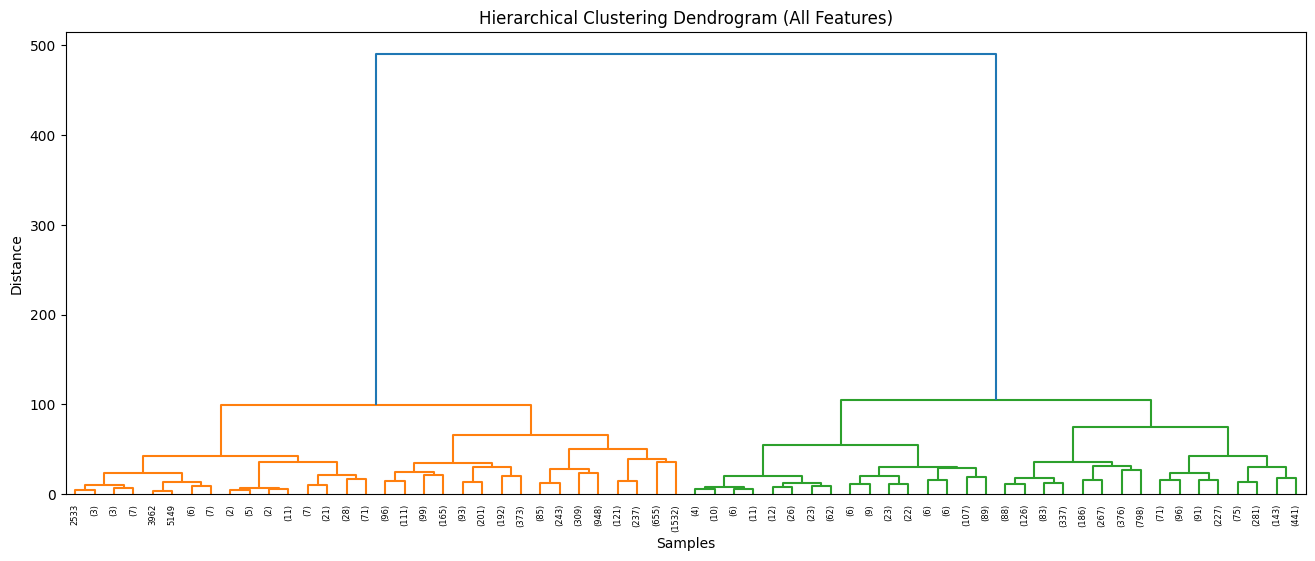

In [77]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

Z = linkage(X, method="ward")

plt.figure(figsize=(16, 6))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram (All Features)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

In [43]:
from sklearn.cluster import AgglomerativeClustering

clusterer = AgglomerativeClustering(
    n_clusters=16,
    linkage="ward"
)

df_cluster["cluster"] = clusterer.fit_predict(X)

In [44]:
df_cluster["cluster"].value_counts().sort_index()

cluster
0      268
1      940
2      859
3     1532
4       29
5     1174
6      471
7     1585
8      485
9      127
10     358
11      20
12     655
13     634
14     154
15     453
Name: count, dtype: int64

In [45]:
price_median_per_cluster = (
    df_cluster
    .groupby("cluster")["price"]
    .median()
)

df_cluster["price_imputed"] = df_cluster["price"]

mask = df_cluster["price"].isna()
df_cluster.loc[mask, "price_imputed"] = (
    df_cluster.loc[mask, "cluster"]
    .map(price_median_per_cluster)
)

In [46]:
df_clean.loc[df_cluster.index, "price"] = df_cluster["price_imputed"]

In [47]:
final_columns = [
    "price","transaction","city","region",
    "surface","bathrooms","rooms","property_type"
]

df_clean = df_clean[final_columns]

## 11) Final Summary

In [48]:
print_section("📊 FINAL DATASET SUMMARY")

print(f"Shape: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns\n")

print("Columns:")
for i, col in enumerate(df_clean.columns, 1):
    dtype = df_clean[col].dtype
    nulls = df_clean[col].isna().sum()
    null_pct = (nulls / len(df_clean)) * 100
    print(f"  {i:2d}. {col:20s} | {str(dtype):15s} | {nulls:,} nulls ({null_pct:.1f}%)")

print("\n" + "="*80)
print("KEY STATISTICS")
print("="*80)

print("\nProperty Type Distribution:")
print(df_clean['property_type'].value_counts())

print("\nTransaction Distribution:")
print(df_clean['transaction'].value_counts(dropna=False))

print("\nTop 10 Cities:")
print(df_clean['city'].value_counts().head(10))

analyze_missing_values(df_clean, "Final Dataset")


                            📊 FINAL DATASET SUMMARY                             

Shape: 9,744 rows × 8 columns

Columns:
   1. price                | float64         | 0 nulls (0.0%)
   2. transaction          | category        | 0 nulls (0.0%)
   3. city                 | category        | 0 nulls (0.0%)
   4. region               | category        | 0 nulls (0.0%)
   5. surface              | float64         | 0 nulls (0.0%)
   6. bathrooms            | Int64           | 0 nulls (0.0%)
   7. rooms                | Int64           | 0 nulls (0.0%)
   8. property_type        | category        | 0 nulls (0.0%)

KEY STATISTICS

Property Type Distribution:
property_type
Appartement    5983
Villa          2337
Maison          974
Studio          450
Name: count, dtype: int64

Transaction Distribution:
transaction
rent    5636
sale    4108
Name: count, dtype: int64

Top 10 Cities:
city
Tunis         3303
Ariana        1703
Nabeul        1317
Sousse        1250
Ben Arous      796
Mahdia   

,Column,Missing,Percent


In [49]:
print("\n=== FINAL CLEANED DATASET (First 10 rows) ===")
display(df_clean.head(10))


=== FINAL CLEANED DATASET (First 10 rows) ===


,price,transaction,city,region,surface,bathrooms,rooms,property_type
0,2100.0,rent,Tunis,Jardins De Carthage,120.0,2,2,Appartement
2,850.0,rent,Sousse,Sousse Jawhara,90.0,1,2,Appartement
3,500000.0,sale,Ariana,La Soukra,144.0,2,3,Appartement
5,850.0,rent,Bizerte,Ras Jebel,400.0,1,2,Villa
6,1800.0,rent,Tunis,Ain Zaghouan Nord,130.0,1,3,Villa
7,1800.0,rent,Tunis,Tunis,65.0,1,1,Appartement
8,1700.0,rent,Tunis,Tunis,80.0,1,1,Appartement
10,410000.0,sale,Bizerte,Ras Jebel,712.0,2,2,Maison
11,550.0,rent,Tunis,Sidi Hassine,60.0,1,2,Appartement
12,154000.0,sale,Ariana,Raoued,440.0,2,3,Villa


In [51]:
print_section("💾 SAVING CLEANED DATA")

# Save in Colab
df_clean.to_csv("C:\\Users\\Mediatek\\Desktop\\ML-project\\ML\\data\\processed\\cleaned_real_estate.csv", index=False)

print(f"✓ Data saved in: C:\\Users\\Mediatek\\Desktop\\ML-project\\ML\\data\\processed\\cleaned_real_estate.csv")
print(f"✓ Total rows: {len(df_clean):,}")
print(f"✓ Total columns: {len(df_clean.columns)}")

print("\n" + "="*80)
print("DATA CLEANING PIPELINE COMPLETE! 🎉")
print("="*80)


                             💾 SAVING CLEANED DATA                              

✓ Data saved in: C:\Users\Mediatek\Desktop\ML-project\ML\data\processed\cleaned_real_estate.csv
✓ Total rows: 9,744
✓ Total columns: 8

DATA CLEANING PIPELINE COMPLETE! 🎉
